In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from models import *
from utils import *
from local_datasets import load_banana, load_ripley, load_two_moon

In [2]:
def make_plot(classifier,title,data,data_labels,labels):
    step = .02
    cmap_base = ListedColormap(['lightcoral', 'cornflowerblue', 'bisque'])
    #cmap_labels = ['lightblue', 'gray', 'green']
    cmap_labels = ['red', 'blue', 'orange']

    #Find Minimum and Maximum value for the data
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1

    #Create Grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),np.arange(y_min, y_max, step))

    #Obtain predicted values for each of the grid's points
    Z = np.array(classifier.predict(np.c_[xx.ravel(), yy.ravel()]))
    for i in range(len(np.unique(Z))):
        Z[np.where(Z == np.unique(Z)[i])] = str(i)
    Z = Z.astype(int)
    Z = Z.reshape(xx.shape)

    #Make Contours
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=cmap_base)

    #Create a Scatterplot with the data
    #labels = np.unique(data_labels)
    
    for i in range(len(labels)):
        plt.scatter(data[data_labels == labels[i], 0], data[data_labels == labels[i], 1],
                    facecolor=cmap_labels[i], label=labels[i],alpha=0.6, edgecolor="black")
    
    plt.legend()

    #Set the limits for the variables
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.title(title)

    plt.xlabel('X0')
    plt.ylabel('X1')
    plt.show()

# B

## Coluna Vertebral

In [3]:
#!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip
#!unzip vertebral_column_data.zip
columns_name = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis','class']
df = pd.read_csv('./datasets./column_3C.dat', names=columns_name, sep=' ')
display(df)

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.03,22.55,39.61,40.48,98.67,-0.25,DH
1,39.06,10.06,25.02,29.00,114.41,4.56,DH
2,68.83,22.22,50.09,46.61,105.99,-3.53,DH
3,69.30,24.65,44.31,44.64,101.87,11.21,DH
4,49.71,9.65,28.32,40.06,108.17,7.92,DH
...,...,...,...,...,...,...,...
305,47.90,13.62,36.00,34.29,117.45,-4.25,NO
306,53.94,20.72,29.22,33.22,114.37,-0.42,NO
307,61.45,22.69,46.17,38.75,125.67,-2.71,NO
308,45.25,8.69,41.58,36.56,118.55,0.21,NO


In [4]:
X = df.iloc[0:, :-1].values
y = df.iloc[0:, -1].values
X = np.array(X)
y = np.array(y)

In [5]:
all_accuracies = []
all_cfmats = []
all_predictions = []
all_x_train = []
all_y_train = []
all_x_test = []
all_y_test = []
all_naivebayes = []
for realization in range(20):
    #Separating train and test subsets from original dataset, with 80/20 proportions
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    #Normalization
    u, s = mean_and_std(X_train)
    X_train = (X_train - u) / s
    X_test = (X_test - u) / s
    all_x_train.append(X_train)
    all_y_train.append(y_train)
    all_x_test.append(X_test)
    all_y_test.append(y_test)

    #Training
    naivebayes = NaiveBayes()
    naivebayes.train(X_train,y_train)
    all_naivebayes.append(naivebayes)

    #Predicting
    predictions = naivebayes.predict(X_test)
    all_predictions.append(predictions)

    #Calculating Accuracy for the n realization and storing it
    accuracy = calc_acc(y_test, predictions)
    all_accuracies.append(accuracy)
    all_cfmats.append(create_cfmat(y_test, predictions))

    #Creating the Confusion Matrix
    cf_matrix = create_cfmat(y_test, predictions)

#Compute the Accuracy (mean of all realization's accuracies) and the standard deviation
mean, std = mean_and_std(all_accuracies)
print("Accuracy mean: ",mean)
print("Accuracy standard deviation",std,'\n')

#Find the realization which it's accuracy is the closest to the mean, i.e, the Accuracy
closest_index = get_closest(mean,all_accuracies)

#Get the X_test, y_test, predicitions, accuracy and trained classifier of the chosen realization
data = all_x_test[closest_index]
data_labels = all_y_test[closest_index]
data_predictions = all_predictions[closest_index]
data_accuracy = all_accuracies[closest_index]
classifier = all_naivebayes[closest_index]

Accuracy mean:  0.832258064516129
Accuracy standard deviation 0.04713431998774986 



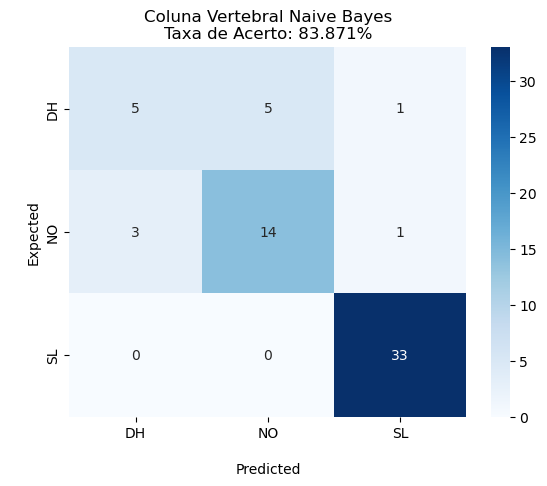

In [6]:
#Generating Confusion Matrix for the realization which it's accuracy is the most similar to the mean
ax = sns.heatmap(all_cfmats[closest_index], annot=True,cmap='Blues',fmt="d")
ax.set_title(f'Coluna Vertebral Naive Bayes\nTaxa de Acerto: {round(data_accuracy,6)*100}%');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('\nExpected');
ax.xaxis.set_ticklabels(np.unique(y))
ax.yaxis.set_ticklabels(np.unique(y))
plt.show()

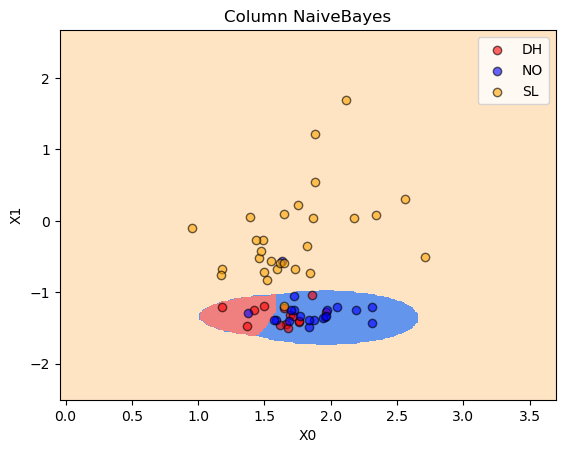

In [7]:
naivebayes_2C = NaiveBayes()
naivebayes_2C.train(all_x_train[-1][:,[4,5]],all_y_train[-1])
make_plot(naivebayes_2C,'Column NaiveBayes',all_x_test[-1][:,[4,5]],all_y_test[-1], np.unique(all_y_test[-1]))

## Two Moon

In [8]:
# importem o código assim

bunch = load_two_moon()
X, y = bunch.data, bunch.target
print(X.shape, y.shape)

(300, 2) (300,)


In [9]:
X = np.array(X)
y = np.array(y)

In [10]:
all_accuracies = []
all_cfmats = []
all_predictions = []
all_x_train = []
all_y_train = []
all_x_test = []
all_y_test = []
all_naivebayes = []
for realization in range(20):
    #Separating train and test subsets from original dataset, with 80/20 proportions
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    #Normalization
    u, s = mean_and_std(X_train)
    X_train = (X_train - u) / s
    X_test = (X_test - u) / s
    all_x_train.append(X_train)
    all_y_train.append(y_train)
    all_x_test.append(X_test)
    all_y_test.append(y_test)

    #Training
    naivebayes = NaiveBayes()
    naivebayes.train(X_train,y_train)
    all_naivebayes.append(naivebayes)

    #Predicting
    predictions = naivebayes.predict(X_test)
    all_predictions.append(predictions)

    #Calculating Accuracy for the n realization and storing it
    accuracy = calc_acc(y_test, predictions)
    all_accuracies.append(accuracy)
    all_cfmats.append(create_cfmat(y_test, predictions))

    #Creating the Confusion Matrix
    cf_matrix = create_cfmat(y_test, predictions)

#Compute the Accuracy (mean of all realization's accuracies) and the standard deviation
mean, std = mean_and_std(all_accuracies)
print("Accuracy mean: ",mean)
print("Accuracy standard deviation",std,'\n')

#Find the realization which it's accuracy is the closest to the mean, i.e, the Accuracy
closest_index = get_closest(mean,all_accuracies)

#Get the X_test, y_test, predicitions, accuracy and trained classifier of the chosen realization
data = all_x_test[closest_index]
data_labels = all_y_test[closest_index]
data_predictions = all_predictions[closest_index]
data_accuracy = all_accuracies[closest_index]
classifier = all_naivebayes[closest_index]

Accuracy mean:  0.885
Accuracy standard deviation 0.029767618499152916 



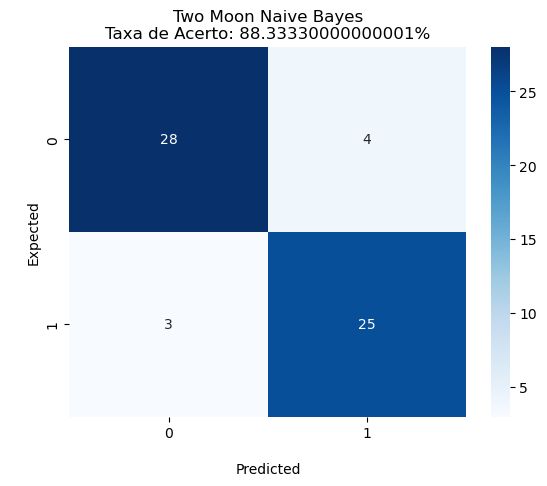

In [11]:
#Generating Confusion Matrix for the realization which it's accuracy is the most similar to the mean
ax = sns.heatmap(all_cfmats[closest_index], annot=True,cmap='Blues',fmt="d")
ax.set_title(f'Two Moon Naive Bayes\nTaxa de Acerto: {round(data_accuracy,6)*100}%');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('\nExpected');
ax.xaxis.set_ticklabels(np.unique(y))
ax.yaxis.set_ticklabels(np.unique(y))
plt.show()

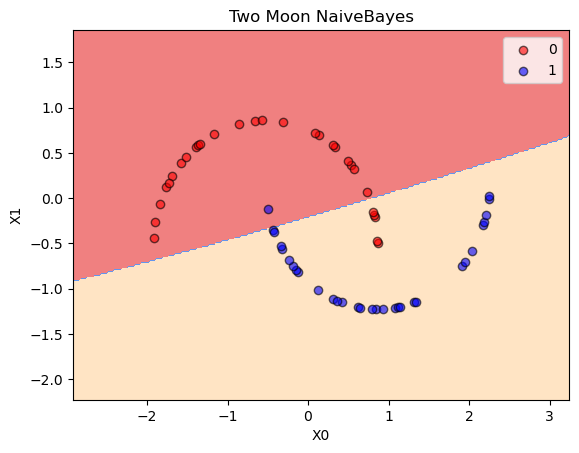

In [12]:
naivebayes_2C = NaiveBayes()
naivebayes_2C.train(all_x_train[-1][:,[0,1]],all_y_train[-1])
make_plot(naivebayes_2C,'Two Moon NaiveBayes',all_x_test[-1][:,[0,1]],all_y_test[-1], np.unique(all_y_test[-1]))

## Ripley

In [13]:
# importem o código assim

bunch = load_ripley()
X, y = bunch.data, bunch.target
print(X.shape, y.shape)

(1249, 2) (1249,)


In [14]:
X = np.array(X)
y = np.array(y)

In [15]:
all_accuracies = []
all_cfmats = []
all_predictions = []
all_x_train = []
all_y_train = []
all_x_test = []
all_y_test = []
all_naivebayes = []
for realization in range(20):
    #Separating train and test subsets from original dataset, with 80/20 proportions
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    #Normalization
    u, s = mean_and_std(X_train)
    X_train = (X_train - u) / s
    X_test = (X_test - u) / s
    all_x_train.append(X_train)
    all_y_train.append(y_train)
    all_x_test.append(X_test)
    all_y_test.append(y_test)

    #Training
    naivebayes = NaiveBayes()
    naivebayes.train(X_train,y_train)
    all_naivebayes.append(naivebayes)

    #Predicting
    predictions = naivebayes.predict(X_test)
    all_predictions.append(predictions)

    #Calculating Accuracy for the n realization and storing it
    accuracy = calc_acc(y_test, predictions)
    all_accuracies.append(accuracy)
    all_cfmats.append(create_cfmat(y_test, predictions))

    #Creating the Confusion Matrix
    cf_matrix = create_cfmat(y_test, predictions)

#Compute the Accuracy (mean of all realization's accuracies) and the standard deviation
mean, std = mean_and_std(all_accuracies)
print("Accuracy mean: ",mean)
print("Accuracy standard deviation",std,'\n')

#Find the realization which it's accuracy is the closest to the mean, i.e, the Accuracy
closest_index = get_closest(mean,all_accuracies)

#Get the X_test, y_test, predicitions, accuracy and trained classifier of the chosen realization
data = all_x_test[closest_index]
data_labels = all_y_test[closest_index]
data_predictions = all_predictions[closest_index]
data_accuracy = all_accuracies[closest_index]
classifier = all_naivebayes[closest_index]

Accuracy mean:  0.8862
Accuracy standard deviation 0.016708081876744572 



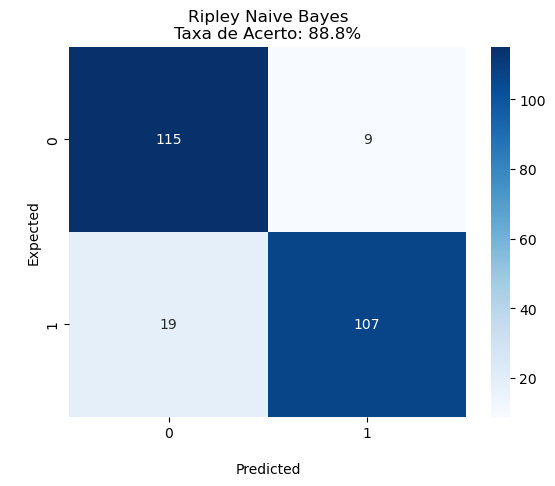

In [16]:
#Generating Confusion Matrix for the realization which it's accuracy is the most similar to the mean
ax = sns.heatmap(all_cfmats[closest_index], annot=True,cmap='Blues',fmt="d")
ax.set_title(f'Ripley Naive Bayes\nTaxa de Acerto: {round(data_accuracy,6)*100}%');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('\nExpected');
ax.xaxis.set_ticklabels(np.unique(y))
ax.yaxis.set_ticklabels(np.unique(y))
plt.show()

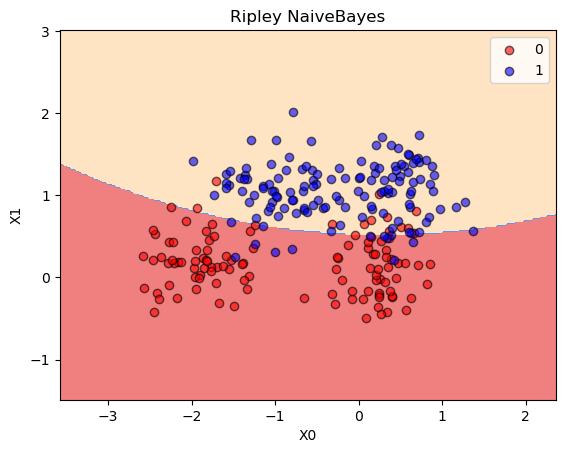

In [17]:
naivebayes_2C = NaiveBayes()
naivebayes_2C.train(all_x_train[-1][:,[0,1]],all_y_train[-1])
make_plot(naivebayes_2C,'Ripley NaiveBayes',all_x_test[-1][:,[0,1]],all_y_test[-1], np.unique(all_y_test[-1]))

## Banana

In [18]:
# importem o código assim

bunch = load_banana()
X, y = bunch.data, bunch.target
print(X.shape, y.shape)

(5300, 2) (5300,)


In [19]:
X = np.array(X)
y = np.array(y)

In [23]:
all_accuracies = []
all_cfmats = []
all_predictions = []
all_x_train = []
all_y_train = []
all_x_test = []
all_y_test = []
all_naivebayes = []
for realization in range(20):
    #Separating train and test subsets from original dataset, with 80/20 proportions
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    #Normalization
    u, s = mean_and_std(X_train)
    X_train = (X_train - u) / s
    X_test = (X_test - u) / s
    all_x_train.append(X_train)
    all_y_train.append(y_train)
    all_x_test.append(X_test)
    all_y_test.append(y_test)

    #Training
    naivebayes = NaiveBayes()
    naivebayes.train(X_train,y_train)
    all_naivebayes.append(naivebayes)

    #Predicting
    predictions = naivebayes.predict(X_test)
    all_predictions.append(predictions)

    #Calculating Accuracy for the n realization and storing it
    accuracy = calc_acc(y_test, predictions)
    all_accuracies.append(accuracy)
    all_cfmats.append(create_cfmat(y_test, predictions))

    #Creating the Confusion Matrix
    cf_matrix = create_cfmat(y_test, predictions)

#Compute the Accuracy (mean of all realization's accuracies) and the standard deviation
mean, std = mean_and_std(all_accuracies)
print("Accuracy mean: ",mean)
print("Accuracy standard deviation",std,'\n')

#Find the realization which it's accuracy is the closest to the mean, i.e, the Accuracy
closest_index = get_closest(mean,all_accuracies)

#Get the X_test, y_test, predicitions, accuracy and trained classifier of the chosen realization
data = all_x_test[closest_index]
data_labels = all_y_test[closest_index]
data_predictions = all_predictions[closest_index]
data_accuracy = all_accuracies[closest_index]
classifier = all_naivebayes[closest_index]

Accuracy mean:  0.6133490566037737
Accuracy standard deviation 0.015077452227804834 



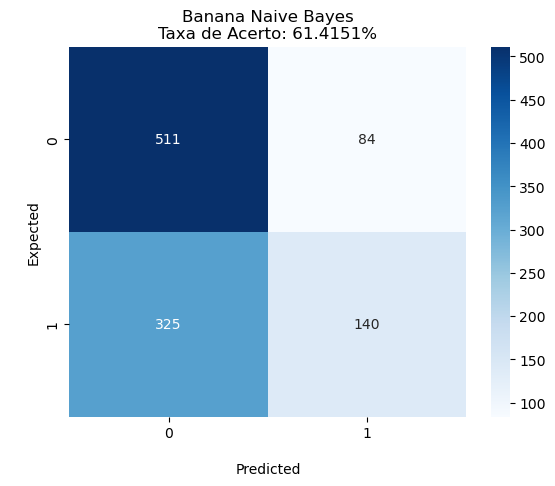

In [24]:
#Generating Confusion Matrix for the realization which it's accuracy is the most similar to the mean
ax = sns.heatmap(all_cfmats[closest_index], annot=True,cmap='Blues',fmt="d")
ax.set_title(f'Banana Naive Bayes\nTaxa de Acerto: {round(data_accuracy,6)*100}%');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('\nExpected');
ax.xaxis.set_ticklabels(np.unique(y))
ax.yaxis.set_ticklabels(np.unique(y))
plt.show()

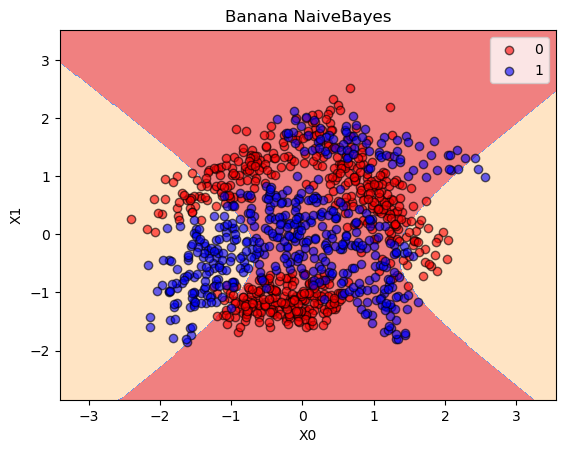

In [25]:
naivebayes_2C = NaiveBayes()
naivebayes_2C.train(all_x_train[-1][:,[0,1]],all_y_train[-1])
make_plot(naivebayes_2C,'Banana NaiveBayes',all_x_test[-1][:,[0,1]],all_y_test[-1], np.unique(all_y_test[-1]))